# Project Tasks

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should combine the profiles and activities and use each data type independently.
* Implement different models for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier top predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session 

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [1]:
import pandas as pd
import re
#import keras

## Mutational catalogs and activities - WGS data

In [177]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.shape

(96, 2782)

Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [178]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.shape

(2780, 68)

In [175]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,ALL::PD4020a,ALL::SJBALL011_D,ALL::SJBALL012_D,ALL::SJBALL020013_D1,ALL::SJBALL020422_D1,ALL::SJBALL020579_D1,ALL::SJBALL020589_D1,ALL::SJBALL020625_D1,...,Stomach-AdenoCa::pfg316T,Stomach-AdenoCa::pfg317T,Stomach-AdenoCa::pfg344T,Stomach-AdenoCa::pfg373T,Stomach-AdenoCa::pfg375T,Stomach-AdenoCa::pfg378T,Stomach-AdenoCa::pfg398T,Stomach-AdenoCa::pfg413T,Stomach-AdenoCa::pfg416T,Stomach-AdenoCa::pfg424T
0,C>A,ACA,35,9,2,7,5,7,3,5,...,133,185,202,185,96,134,12,279,75,135
1,C>A,ACC,16,2,4,10,5,9,1,2,...,48,70,126,88,35,54,16,112,31,91


In [176]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,...,0,0,0,0,0,0,0,0,0,0


## Mutational catalogs - WES data

In [76]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

,Mutation type,Trinucleotide,AML::TCGA-AB-2802-03B-01W-0728-08,AML::TCGA-AB-2803-03B-01W-0728-08,AML::TCGA-AB-2804-03B-01W-0728-08,AML::TCGA-AB-2805-03B-01W-0728-08,AML::TCGA-AB-2806-03B-01W-0728-08,AML::TCGA-AB-2807-03B-01W-0728-08,AML::TCGA-AB-2808-03B-01W-0728-08,AML::TCGA-AB-2809-03D-01W-0755-09,...,Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08
0,C>A,ACA,0,0,0,0,4,0,2,0,...,1,0,0,0,0,0,0,0,0,0
1,C>A,ACC,0,2,0,0,0,1,3,0,...,0,0,0,0,0,0,0,1,0,0


In [163]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,AML,TCGA-AB-2802-03B-01W-0728-08,0.811,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AML,TCGA-AB-2803-03B-01W-0728-08,0.608,4,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

,Mutation type,Trinucleotide,ALL::TARGET-10-PAIXPH-03A-01D,ALL::TARGET-10-PAKHZT-03A-01R,ALL::TARGET-10-PAKMVD-09A-01D,ALL::TARGET-10-PAKSWW-03A-01D,ALL::TARGET-10-PALETF-03A-01D,ALL::TARGET-10-PALLSD-09A-01D,ALL::TARGET-10-PAMDKS-03A-01D,ALL::TARGET-10-PAPJIB-04A-01D,...,Head-SCC::V-109,Head-SCC::V-112,Head-SCC::V-116,Head-SCC::V-119,Head-SCC::V-123,Head-SCC::V-124,Head-SCC::V-125,Head-SCC::V-14,Head-SCC::V-29,Head-SCC::V-98
0,C>A,ACA,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
1,C>A,ACC,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [9]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,TARGET-10-PAIXPH-03A-01D,0.529,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,ALL,TARGET-10-PAKHZT-03A-01R,0.696,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [10]:
#Exploring the datasets...

In [11]:
PCAWG_wgs_mut

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137
2,C>A,ACG,25,13,13,29,8,31,12,15,...,12,29,14,19,51,13,52,14,49,32
3,C>A,ACT,154,70,73,126,31,119,41,122,...,82,213,66,68,271,68,281,80,202,116
4,C>A,CCA,215,63,71,129,30,190,54,133,...,119,188,67,89,307,69,339,204,194,127
5,C>A,CCC,148,49,55,82,22,175,39,96,...,70,132,51,45,469,52,170,390,124,100
6,C>A,CCG,27,7,8,26,10,46,8,17,...,19,23,15,16,111,16,52,92,28,17
7,C>A,CCT,180,69,61,143,38,159,41,165,...,186,188,60,63,1073,55,261,876,150,120
8,C>A,GCA,165,81,61,162,21,181,48,142,...,79,158,55,78,250,73,264,77,142,108
9,C>A,GCC,76,37,50,84,25,331,39,67,...,64,86,34,30,194,32,137,62,95,72


In [162]:
#Get the number of samples per tumor type
import numpy as np
mutTypes = np.array(PCAWG_wgs_mutT.index.str.split("::").str[0])
unique, counts = np.unique(mutTypes, return_counts=True)
sampCounts = dict(zip(unique, counts))
dict(zip(unique, counts))

{'Biliary-AdenoCA': 35,
 'Bladder-TCC': 23,
 'Bone-Benign': 16,
 'Bone-Epith': 11,
 'Bone-Osteosarc': 38,
 'Breast-AdenoCA': 198,
 'Breast-DCIS': 3,
 'Breast-LobularCA': 13,
 'CNS-GBM': 41,
 'CNS-Medullo': 146,
 'CNS-Oligo': 18,
 'CNS-PiloAstro': 89,
 'Cervix-AdenoCA': 2,
 'Cervix-SCC': 18,
 'ColoRect-AdenoCA': 60,
 'Eso-AdenoCA': 98,
 'Head-SCC': 57,
 'Kidney-ChRCC': 45,
 'Kidney-RCC': 144,
 'Liver-HCC': 326,
 'Lung-AdenoCA': 38,
 'Lung-SCC': 48,
 'Lymph-BNHL': 107,
 'Lymph-CLL': 95,
 'Myeloid-AML': 11,
 'Myeloid-MDS': 4,
 'Myeloid-MPN': 56,
 'Ovary-AdenoCA': 113,
 'Panc-AdenoCA': 241,
 'Panc-Endocrine': 85,
 'Prost-AdenoCA': 286,
 'Skin-Melanoma': 107,
 'SoftTissue-Leiomyo': 15,
 'SoftTissue-Liposarc': 19,
 'Stomach-AdenoCA': 75,
 'Thy-AdenoCA': 48,
 'Uterus-AdenoCA': 51}

In [83]:
#Rotate the the PCAWG_wgs_mut dataset
#Remove rows for "Mutation type" and "Trinucleotide"
#Add a column telling the cancer type of the sample in a row (Used for the labeling in the classifier)
PCAWG_wgs_mutT = PCAWG_wgs_mut.T
PCAWG_wgs_mutT = PCAWG_wgs_mutT.drop(["Mutation type", "Trinucleotide"])
PCAWG_wgs_mutT["type"] = PCAWG_wgs_mutT.index.str.split("::").str[0]

In [80]:
#PCAWG_wgs_mutT

In [17]:
#Random forest classifier for the whole unmodified dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

y = PCAWG_wgs_mutT['type'] #Labels
X = PCAWG_wgs_mutT.drop(['type'], axis = 1) #Data
#split the dataset to train and test data, the library can do this automatically
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.7050359712230215


In [169]:
#Normalising each row so that the mutations sum to 1
for i in range(len(PCAWG_wgs_mutT)):
    PCAWG_wgs_mutT.iloc[i][:96] = PCAWG_wgs_mutT.iloc[i][:96] / sum(PCAWG_wgs_mutT.iloc[i][:96])

In [170]:
PCAWG_wgs_mutT.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,type
Biliary-AdenoCA::SP117655,0.0180537,0.00993289,0.00167785,0.0103356,0.0144295,0.00993289,0.00181208,0.0120805,0.0110738,0.00510067,...,0.0179866,0.00127517,0.00114094,0.00288591,0.00597315,0.00557047,0.00322148,0.00422819,0.0132215,Biliary-AdenoCA
Biliary-AdenoCA::SP117556,0.0224057,0.0110063,0.00255503,0.0137579,0.0123821,0.0096305,0.00137579,0.0135613,0.0159198,0.00727201,...,0.0104167,0.00157233,0.000982704,0.00393082,0.00294811,0.00511006,0.00196541,0.00609277,0.0125786,Biliary-AdenoCA
Biliary-AdenoCA::SP117627,0.0177275,0.0119872,0.00219483,0.0123248,0.0119872,0.00928583,0.00135067,0.0102988,0.0102988,0.00844167,...,0.00742867,0.00118183,0.001013,0.00236367,0.00236367,0.00270133,0.00135067,0.0025325,0.00877933,Biliary-AdenoCA
Biliary-AdenoCA::SP117775,0.0174845,0.00991056,0.00233664,0.0101523,0.010394,0.00660704,0.00209492,0.011522,0.0130529,0.00676819,...,0.0106357,0.00169205,0.000564016,0.00225606,0.00273951,0.0030618,0.00241721,0.00427041,0.00982999,Biliary-AdenoCA
Biliary-AdenoCA::SP117332,0.0150463,0.0104167,0.00231481,0.00896991,0.00868056,0.00636574,0.00289352,0.0109954,0.00607639,0.0072338,...,0.00520833,0.000578704,0.00115741,0.00202546,0.00202546,0.00434028,0.00231481,0.00462963,0.0109954,Biliary-AdenoCA


In [172]:
#Random forest classifier for the normalised dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

y = PCAWG_wgs_mutT['type'] #Labels
X = PCAWG_wgs_mutT.drop(['type'], axis = 1) #Data
#split the dataset to train and test data, the library can do this automatically
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.7381294964028777


Maybe a bit better results than for the non-normalised data?

In [229]:
#Leave out cancer types with less than 50 samples
prunedTypes = []
for tumorType in sampCounts.keys():
    if sampCounts[tumorType] >= 50:
        prunedTypes.append(tumorType)

PCAWG_wgs_mutOver50samp = PCAWG_wgs_mutT.loc[PCAWG_wgs_mutT['type'] == prunedTypes[0]]
for type in prunedTypes[1:]: 
    
    PCAWG_wgs_mutOver50samp = pd.concat([PCAWG_wgs_mutOver100samp, PCAWG_wgs_mutT.loc[PCAWG_wgs_mutT['type'] == type]])
  

In [230]:
PCAWG_wgs_mutOver50samp

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,type
Breast-AdenoCA::SP117956,0.0181441,0.0150337,0.00259202,0.0139969,0.0129601,0.0119233,0.00259202,0.00881286,0.00414723,0.00777605,...,0.00311042,0.00155521,0.00207361,0.0139969,0.00155521,0.00259202,0.00311042,0.00466563,0.00725765,Breast-AdenoCA
Breast-AdenoCA::SP117975,0.0144,0.0144,0.0008,0.0088,0.0148,0.006,0.0024,0.0056,0.0116,0.0072,...,0.0052,0.0036,0.002,0.004,0.0028,0.0048,0.0028,0.0064,0.0076,Breast-AdenoCA
Breast-AdenoCA::SP2149,0.0196915,0.0164247,0.00326679,0.0209619,0.0172414,0.015245,0.00290381,0.0147005,0.0137931,0.0105263,...,0.00744102,0.00499093,0.00254083,0.00626134,0.00526316,0.00517241,0.00453721,0.00816697,0.011706,Breast-AdenoCA
Breast-AdenoCA::SP117113,0.0236183,0.00944733,0.00236183,0.0113368,0.0155881,0.0070855,0.0014171,0.0127539,0.023146,0.0099197,...,0.0056684,0,0.000472367,0.0028342,0.000944733,0.00188947,0.000944733,0.0014171,0.00803023,Breast-AdenoCA
Breast-AdenoCA::SP117245,0.0137904,0.0126084,0.00118203,0.00945626,0.00906225,0.00866824,0.00157604,0.00866824,0.0110323,0.0106383,...,0.0035461,0.00157604,0.000788022,0.00275808,0.00197006,0.00236407,0.00236407,0.00157604,0.0126084,Breast-AdenoCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uterus-AdenoCA::SP92931,0.0279116,0.0150602,0.00261044,0.0136546,0.0138554,0.0104418,0.00321285,0.0110442,0.0146586,0.0064257,...,0.0164659,0.00160643,0.00180723,0.00281124,0.00461847,0.00381526,0.00261044,0.00502008,0.013253,Uterus-AdenoCA
Uterus-AdenoCA::SP91265,0.0258692,0.0163284,0.0033297,0.0179932,0.0217071,0.0108856,0.0033297,0.0167126,0.0169047,0.00877249,...,0.0147275,0.00364987,0.00204905,0.00621118,0.00755587,0.00531472,0.00313761,0.00691554,0.0142793,Uterus-AdenoCA
Uterus-AdenoCA::SP89909,0.00532119,0.0042789,0.000768007,0.00438861,0.011191,0.0213945,0.0050469,0.0480553,0.00422404,0.00340117,...,0.00416918,0.000548576,0.000384004,0.000548576,0.00131658,0.0010423,0.00093258,0.00186516,0.00581491,Uterus-AdenoCA
Uterus-AdenoCA::SP90629,0.00718535,0.00540339,0.00140833,0.00580577,0.00557583,0.00356394,0.00080476,0.00431121,0.00408128,0.00273043,...,0.00566206,0.00120714,0.00100595,0.00206938,0.00324778,0.00310407,0.00264421,0.00296037,0.00776018,Uterus-AdenoCA


In [234]:
#Random forest classifier for the dataset with only tumors with over 100 samples
y = PCAWG_wgs_mutOver50samp['type'] #Labels
X = PCAWG_wgs_mutOver50samp.drop(['type'], axis = 1) #Data
#split the dataset to train and test data, the library can do this automatically
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.7822445561139029


Seems to be on average a bit better again

In [ ]:
#Random forest classifier for signature activity data

In [270]:
PCAWG_wgs_act

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Biliary-AdenoCA,SP117627,0.973,1110,528,0,0,1453,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Biliary-AdenoCA,SP117775,0.987,1803,1271,0,0,2199,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Biliary-AdenoCA,SP117332,0.987,441,461,0,0,840,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,Uterus-AdenoCA,SP92931,0.978,1001,0,0,0,788,0,0,...,0,0,0,0,0,0,0,0,0,0
2776,Uterus-AdenoCA,SP91265,0.962,1300,0,0,0,1108,0,0,...,0,0,0,0,0,0,0,0,0,0
2777,Uterus-AdenoCA,SP89909,0.990,2508,0,0,0,6908,0,0,...,0,0,0,0,0,0,0,0,0,0
2778,Uterus-AdenoCA,SP90629,0.995,1029,7017,0,0,10940,0,0,...,0,0,0,0,0,0,0,0,0,0


In [272]:
#Drop columns "Sample Names" and "Accuracy"
#Normalise the dataset so rows sum to 1
PCAWG_wgs_actNorm = PCAWG_wgs_act.drop(["Sample Names", "Accuracy"], axis = 1)
for i in range(len(PCAWG_wgs_actNorm)):
    PCAWG_wgs_actNorm.iloc[i] = PCAWG_wgs_actNorm.iloc[i][1:] / sum(PCAWG_wgs_actNorm.iloc[i][1:])
PCAWG_wgs_actNorm["Cancer Types"] = PCAWG_wgs_act["Cancer Types"]

In [283]:
PCAWG_wgs_actNorm.head()

,Cancer Types,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,0.100403,0.086980,0.0,0.0,0.122483,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Biliary-AdenoCA,0.193593,0.000000,0.0,0.0,0.181211,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Biliary-AdenoCA,0.187405,0.089144,0.0,0.0,0.245315,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Biliary-AdenoCA,0.145274,0.102409,0.0,0.0,0.177182,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Biliary-AdenoCA,0.127604,0.133391,0.0,0.0,0.243056,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [292]:
#Random forest classifier for the whole unmodified signature activity dataset
PCAWG_wgs_actDrop = PCAWG_wgs_act.drop(["Sample Names", "Accuracy"], axis = 1)
y = PCAWG_wgs_actDrop['Cancer Types']
X = PCAWG_wgs_actDrop.drop(['Cancer Types'], axis = 1)# Split the dataset to train and test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.637410071942446


In [296]:
#Random forest classifier for the normalised signature activity dataset
y = PCAWG_wgs_actNorm['Cancer Types']
X = PCAWG_wgs_actNorm.drop(['Cancer Types'], axis = 1)# Split the dataset to train and test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.5726618705035971


The result actually gets worse

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
cancer_type = list(set(y))
cm = np.array(confusion_matrix(test_y, RF_predictions, labels=cancer_type))
confusion = pd.DataFrame(cm, index=cancer_type, columns=cancer_type)

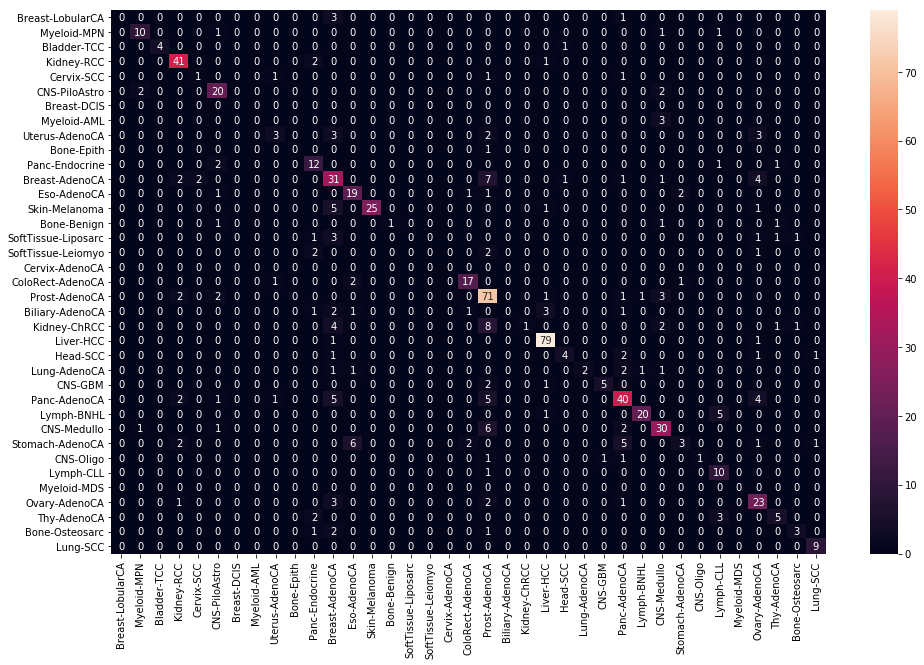

In [43]:
fig, ax = plt.subplots(figsize = (16,10))
ax = sns.heatmap(confusion, annot=True)

In [60]:
#Support vector machine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
svc_model = SVC()

y = PCAWG_wgs_mutT['type'] #Labels
X = PCAWG_wgs_mutT.drop(['type'], axis = 1) #Data
#split the dataset to train and test data, the library can do this automatically
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)


In [61]:
svc_model.fit(train_X, train_y)
y_predict = svc_model.predict(test_X)
score = accuracy_score(test_y, y_predict)
score

0.13525179856115108

In [63]:
#Neural network 
from sklearn.neural_network import MLPClassifier

In [70]:
neural_model = MLPClassifier(activation='logistic', solver='sgd',
               hidden_layer_sizes=(10,15), random_state=1)
y = PCAWG_wgs_mutT['type'] #Labels
X = PCAWG_wgs_mutT.drop(['type'], axis = 1) #Data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)
neural_model.fit(X, y)

/Users/battle_g_5/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 15), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [71]:
y_predict = neural_model.predict(test_X)
score = accuracy_score(test_y, y_predict)
score

0.2143884892086331

In [72]:
#Naive Bias Classifier
from sklearn.naive_bayes import GaussianNB

In [73]:
NB_model = GaussianNB()
y = PCAWG_wgs_mutT['type'] #Labels
X = PCAWG_wgs_mutT.drop(['type'], axis = 1) #Data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)
NB_model.fit(X, y)

GaussianNB(priors=None)

In [74]:
y_predict = NB_model.predict(test_X)
score = accuracy_score(test_y, y_predict)
score

0.32805755395683456

In [77]:
TCGA_wes_mut.head(2)

,Mutation type,Trinucleotide,AML::TCGA-AB-2802-03B-01W-0728-08,AML::TCGA-AB-2803-03B-01W-0728-08,AML::TCGA-AB-2804-03B-01W-0728-08,AML::TCGA-AB-2805-03B-01W-0728-08,AML::TCGA-AB-2806-03B-01W-0728-08,AML::TCGA-AB-2807-03B-01W-0728-08,AML::TCGA-AB-2808-03B-01W-0728-08,AML::TCGA-AB-2809-03D-01W-0755-09,...,Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08
0,C>A,ACA,0,0,0,0,4,0,2,0,...,1,0,0,0,0,0,0,0,0,0
1,C>A,ACC,0,2,0,0,0,1,3,0,...,0,0,0,0,0,0,0,1,0,0


In [96]:
TCGA_wes_mut = TCGA_wes_mut.T
#TCGA_wes_mut = TCGA_wes_mut.drop(["cancer_type"])
TCGA_wes_mut["type"] = TCGA_wes_mut.index.str.split("::").str[0]

In [97]:
TCGA_wes_mut.head(2)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,type
AML::TCGA-AB-2802-03B-01W-0728-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,AML
AML::TCGA-AB-2803-03B-01W-0728-08,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AML


In [81]:
PCAWG_wgs_mutT.head(2)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,type
Biliary-AdenoCA::SP117655,269,148,25,154,215,148,27,180,165,76,...,268,19,17,43,89,83,48,63,197,Biliary-AdenoCA
Biliary-AdenoCA::SP117556,114,56,13,70,63,49,7,69,81,37,...,53,8,5,20,15,26,10,31,64,Biliary-AdenoCA


In [130]:
df = pd.concat([PCAWG_wgs_mutT, TCGA_wes_mut], sort=False)
df.drop(df.tail(1).index,inplace=True)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,type
Biliary-AdenoCA::SP117655,269,148,25,154,215,148,27,180,165,76,...,268,19,17,43,89,83,48,63,197,Biliary-AdenoCA
Biliary-AdenoCA::SP117556,114,56,13,70,63,49,7,69,81,37,...,53,8,5,20,15,26,10,31,64,Biliary-AdenoCA


In [131]:
cancer_type = df['type']

In [133]:
from sklearn import preprocessing
df = df.iloc[:,:96]
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
Biliary-AdenoCA::SP117655,269,148,25,154,215,148,27,180,165,76,...,49,268,19,17,43,89,83,48,63,197
Biliary-AdenoCA::SP117556,114,56,13,70,63,49,7,69,81,37,...,23,53,8,5,20,15,26,10,31,64


In [134]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

/Users/battle_g_5/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [135]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.035334,0.024479,0.011421,0.003558,0.017252,0.012172,0.007967,0.001751,0.027509,0.007927,...,0.004608,0.003754,0.005053,0.002660,0.012031,0.004557,0.002112,0.002197,0.006894,0.000517
1,0.014974,0.009262,0.005939,0.001617,0.005055,0.004030,0.002066,0.000671,0.013505,0.003859,...,0.002163,0.000742,0.002128,0.000782,0.005596,0.000768,0.000662,0.000458,0.003392,0.000168


In [136]:
y = cancer_type
X = df
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.4750733137829912


After adding exome data, random forest classifiers performance degrades.

In [138]:
#Combining all the data
df.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.035334,0.024479,0.011421,0.003558,0.017252,0.012172,0.007967,0.001751,0.027509,0.007927,...,0.004608,0.003754,0.005053,0.002660,0.012031,0.004557,0.002112,0.002197,0.006894,0.000517
1,0.014974,0.009262,0.005939,0.001617,0.005055,0.004030,0.002066,0.000671,0.013505,0.003859,...,0.002163,0.000742,0.002128,0.000782,0.005596,0.000768,0.000662,0.000458,0.003392,0.000168
2,0.013792,0.011743,0.005939,0.001687,0.005697,0.004523,0.002361,0.000593,0.010170,0.005215,...,0.000752,0.000616,0.001862,0.000939,0.003917,0.000717,0.000407,0.000366,0.001641,0.000136
3,0.028504,0.020344,0.013248,0.002911,0.010351,0.006744,0.007672,0.001391,0.027009,0.008762,...,0.004044,0.001849,0.005585,0.001095,0.007834,0.001741,0.000967,0.001373,0.005799,0.000320
4,0.006830,0.005954,0.003655,0.000716,0.002407,0.001809,0.002951,0.000370,0.003501,0.002608,...,0.000752,0.000252,0.000532,0.000626,0.001959,0.000358,0.000382,0.000366,0.001751,0.000100


In [160]:
nonPCAWG_wgs_act.head()

,SBS7d,SBS8,SBS9,SBS10a,SBS10b,SBS11,SBS12,SBS13,SBS14,SBS15,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,0,0,0,0,0,0,0,4284,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
other_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,TARGET-10-PAIXPH-03A-01D,0.529,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,ALL,TARGET-10-PAKHZT-03A-01R,0.696,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [167]:
#nonPCAWG_wgs_act['signature'] = nonPCAWG_wgs_act.column
nonPCAWG_wgs_act = nonPCAWG_wgs_act.iloc[:,3:]
nonPCAWG_wgs_act = nonPCAWG_wgs_act.T

In [172]:
nonPCAWG_wgs_act['signature'] = nonPCAWG_wgs_act.index
nonPCAWG_wgs_act.shape

(59, 1866)